# USGS Data Analysis Pre-and-Post Fire after the 2017 Wine Country Fires

In [2]:
library(dataRetrieval)
library(EGRET)
library(zoo)
library(leaflet)
library(dplyr)


As a data scientist, today you are going to be investigating the impact our the recent North Bay wildfires on the health of the Russian River. The Russian River is a critical source of water for hundreds of plants, fish and animals. The river also provides a critical water supply for agriculture. Local populations use the River and watershed areas produced from it for fishing, recreation and over 600,000 residents use the filtered drinking water from the river every day. As scientists interested in the health of our local communities and environment, it is important we understand how climate conditions and natural disasters impact our resources. 

First, look at how the fire impacted the region using Drone Imagery. Note how the river flows through the areas around Santa Rosa, Guerneville, Healdsburg, and Ukiah, California, just north of San Francisco.

Drone Imagery: https://www.sonomasheriff.org/tubbscomplexlnu-fire-imagery

## Functions to Retrieve Daily Data

In [3]:

###############=======Functions to retrieve the daily data. Must be run as a chunk============##########

#Next, we need to run some functions.
#What is a function? Why do we use them in our code?

# Highlight all of the code for the entire function and press run. This will allow us to use the function later 
# Put your cursor at the beginning of each function 'getFlowDaily' and 'getWQDaily'
# Functions take information, and give you an output


getFlowDaily<-function (siteNumber, parameterCd = "00060", startDate = "", endDate = "", interactive = TRUE, convert = TRUE,statCd) {
  #statCd <- ifelse("00060" == parameterCd, "00003", "00001")
  url <- dataRetrieval::constructNWISURL(siteNumber, parameterCd, startDate, endDate, "dv", statCd, format = "tsv")
  data <- dataRetrieval::importRDB1(url, asDateTime = FALSE)
  if (nrow(data) > 0) {
    names(data) <- c("agency", "site", "dateTime", "value", "code")
    data$dateTime <- as.Date(data$dateTime)
  }
  qConvert <- ifelse("00060" == parameterCd, 35.314667, 1)
  qConvert <- ifelse(convert, qConvert, 1)
  indx<-which(is.na(data$value))
  data$value[indx]<-(data$value[indx-2]+data$value[indx-3])/2
  localDaily <- populateDaily(data, qConvert, interactive = interactive)
  return(localDaily)
}


getWQDaily<-function (siteNumber, parameterCd = "00060", startDate = "", endDate = "", interactive = TRUE, convert = TRUE,statCd) {
  statCd <- ifelse("00060" == parameterCd, "00003", "00001")
  url <- dataRetrieval::constructNWISURL(siteNumber, parameterCd, startDate, endDate, "dv", statCd = statCd, format = "tsv")
  data <- dataRetrieval::importRDB1(url, asDateTime = FALSE)
  indx<-nrow(data )
  if(indx < 2) {
    return(NA)
  } else{names(data) <- c("agency", "site", "dateTime", "value", "code")
  data$dateTime <- as.Date(data$dateTime)
  }
  
  if("63680" == parameterCd){
    data[is.na(data[,4]),4]<-as.numeric(data[is.na(data[,4]),6])
  }
  
  data[,4]<-as.numeric(data[,4])
  
  
  qConvert <- ifelse("00060" == parameterCd, 35.314667, 1)
  qConvert <- ifelse(convert, qConvert, 1)
  data<-transform(data, value = na.locf(value)) #means last observation carried forward when NA found
  indx<-which(data$value<0.01)
  
  if(length(indx)>1) {
    data$value[indx]<-NA
    data<-transform(data, value = na.locf(value)) #some Q is <0 so label as NA then used last observation
  }else{data<-data}
  
  localDaily <- populateDaily(data, qConvert, interactive = FALSE)
  localDaily$Day<-as.numeric(format.Date(localDaily$Date,format="%j"))
  return(localDaily)
}



##################=======End of Functions to retrieve the daily data============##########

## Gather water quality data:

As Scientists, you have to decide where you put various sensors to collect your data. Look at the sites where we have sensors to collect data about the Russian River water quality. 

Go to https://maps.waterdata.usgs.gov/ 

Even though Guerneville is not directly inside a fire-perimeter, it is still a fire-impacted site because the watershed drains water from all of the fire-zones through streams and tributaries that eventually merge into the Russian River. Since Guerneville receives so much water that has traveled through these fire-impacted areas, the water qualtiy will reflect the history of its travel path.

Look at the river sites around Santa Rosa, Guerneville, Healdsburg, and Ukiah, California, just north of San Francisco

Click on a few of the sites around RUSSIAN R NR GUERNEVILLE CA  

As a Scientist, you have to decide where to collect your data, and also what data to access to answer certain questions. Today we are going to be looking at data from Guerneville. Based on the map, what can you determine about this area and how this part of the river may or may not have been impacted by the fire?

Each sensor is collecting all kinds of data. Look at this website to see the different types of data we could collect.

Here is the list of all United States Geological Survey (USGS) optional parameters: https://help.waterdata.usgs.gov/codes-and-parameters/parameters

Click on the HTML for "Physical parameters" and find	pH, water, unfiltered, field, standard units.

Task: Note the five-digit code for pH. We will need this when we go to fetch our data.



In [5]:
############################### Station 1: Gather water quality data:==============###########

#Now we can fetch the specific data for pre and post-fire from Guerneville.

# Specify the site #1: Fill in the ? with the site number for Guerneville
siteID <- "11467000" #Guerneville, CA

startDate <- "" #Gets earliest date 2009-06-01
endDate <- "2018-07-11" #Gets data up until Jan 24 2018

#### Specify the parameter code  for the water quality and fetch pH data: 

parameter_cd<-"00400" #5 digit USGS code for pH. Place number within quotes, no spaces

#Fetch daily water quality data: pH 
DailypH_1 <- getWQDaily(siteID,parameter_cd,startDate,endDate)
names(DailypH_1)<-c("Date","pH","Julian","Month","Day","DecYear","MonthSeq","waterYear","Qualifier","i","Log","Q7","Q30")

#What do all of these components of the code mean?
#Name definitions
# Date-Actual date
# pH- values for the the variable pH which is acidity
# Julian-day of the year
# Month-Month labeled as a number Jan=1, Feb=2
# Day-Day of the month
# DecYear-Date converted to a decimal
# MonthSeq-Number of months after 1850
# waterYear- hydrological years begin in September. (Sept 2015-August 2016 is the 2016 water year)
# Qualifier-quality codes
# i-measuremen number
# log-log of the data values
# Q7-7 day running average
# Q30-30 day running average


## Plot the pH data by month

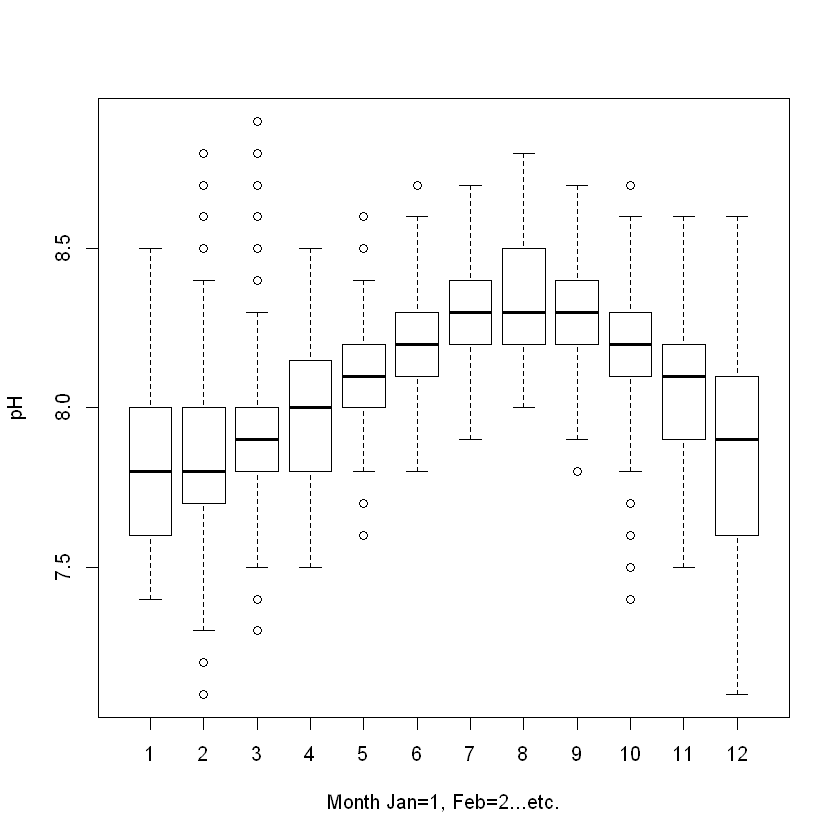

In [6]:

#######################================Plot the pH data by month============##########

boxplot(DailypH_1$pH~DailypH_1$Month,xlab="Month Jan=1, Feb=2...etc.",ylab="pH")



Question: Where does the water go when it falls on the hillslopes of a drainage basin? Water will drain downward into the soil and into the river

Question: What do you think may happen when water runs off the burned landscape into a river? It causes debris flows, landslides, and leaches contaminated water into the river
##***Facilitator Note: The River flowed from the fire area to this site…***Add more explanation

Discuss: What is ph?

Question: What is the meaning of pH? What values are more acidic and what values are more basic? Why would this matter in a river setting?

Discuss: Why is this important for our understanding of the river health? ***Add facilitator notes, do not have students go to the website to answer. pH is an important indicator of river health. While young fish and insect larvae are sensitive to a low pH (acid), extreme values on either end of the scale can be lethal to most organisms.

## What is a Drainage Basin

Question: Where does the water go when it falls on the hillslopes of a drainage basin? Water will drain downward into the soil and into the river

Question: What do you think may happen when water runs off the burned landscape into a river? It causes debris flows, landslides, and leaches contaminated water into the river

![Image of Drainage Basin](https://bit.ly/2L2PV1t)

## Classify the pH data

In [7]:
#######################================Classify the pH data============##########
#Here we are going to categorize our dates as pre-fire and post-fire
#What does it mean to categorize in this way?
DailypH_1$prepost<-NA
DailypH_1$prepost[DailypH_1$Date < "2017-09-30"]<-"preFire" #dates before Sept. 30, 2017 are 0 for pre
DailypH_1$prepost[DailypH_1$Date > "2017-09-30"]<-"postFire" #dates after Sept. 30, 2017 are 1 for post

## Plot pre-and-post fire pH

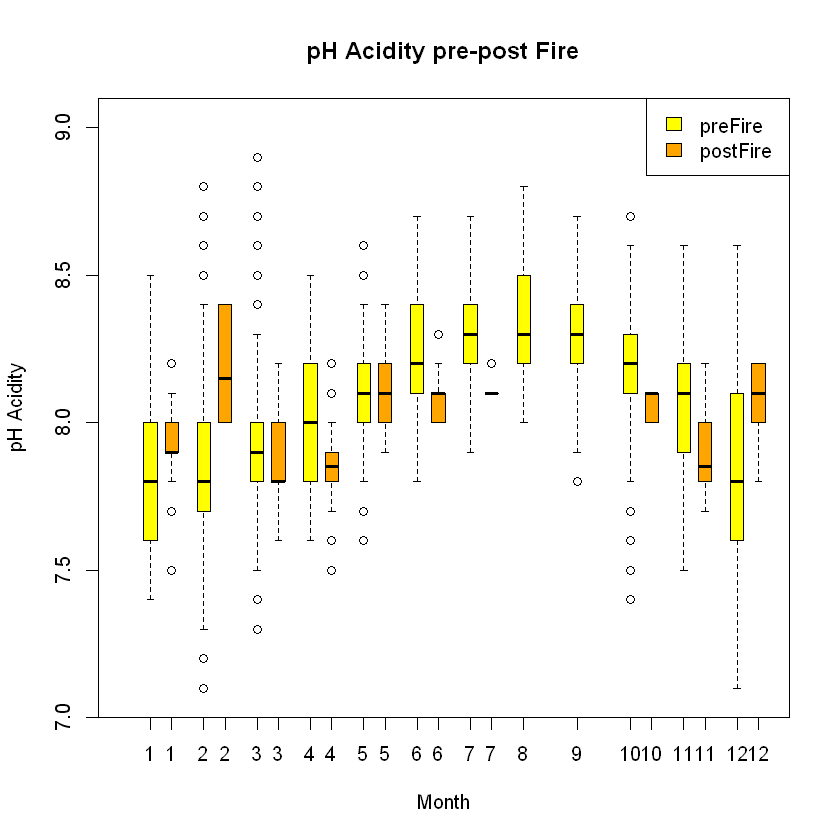

In [9]:

#############################Color the box plot by pre-post fire and combine by month

boxplot(pH~Month, data = DailypH_1,boxwex = 0.25,at = 1:12 - 0.2,subset = prepost == "preFire", col = "yellow", main = "pH Acidity pre-post Fire",xlab= "Month",ylab = "pH Acidity",ylim = c(7, ceiling( max(DailypH_1$pH)) + 0.1), yaxs= "i")

boxplot(pH~Month,data = DailypH_1,boxwex  = 0.25, at = c(1:7,10:12) + 0.2,subset  = prepost == "postFire",col = "orange", add = TRUE)

legend("topright",legend = c( "preFire", "postFire" ), fill = c( "yellow", "orange" ) )
############################

## Questions to Discuss


############=======Questions============##########

Question: How does the pH differ pre and post Fire in October and November?
Question: How does the pH differ pre and post Fire in December, January, February?
Speculate on some reasons why
Question: How does the pH vary across the year? Why would it be higher in summer and lower in winter?

Facilitator's Note: Have students discuss and brainstorm ideas to why the ph may vary. 
pH is higher in the summer for a variety of reasons. 1) There is no rainfall in summer. Rainfall is typically more acidic, so in the summer there is no longer an input of acidic water. 2) aquatic plants and algae bloom during this time and they consume a lot of co2. Because they consume co2 this makes the water more basic. 3) During low flows (summer time), water has more of an opportunity to interact with riverbed sediments and minerals which oftentimes helps to neutralize water. 

OPTION 1 - pH may naturally vary over the years. Biological factors such as bacteria producting co2, or aquatic vegetation consuming co2 directly impacts pH. Maybe the plants and bacteria have changed?
How would we test this?
Might look at pH variability over a few years. Test theory by looking at code below.

OPTION 2 - pH may be impacted by discharge events. This means it might be impacted by rainfall.
How would we test this?
Might look at pH variability across discharge events. Test theory by looking at code below.

OPTION 3 - pH may be impacted by runoff in our drainage basin, the Russian River Watershed. This means it might be impacted by rainfall, but also by the rainfall coming into contact with the burn areas.
How would we test this?
Might look at pH variability across discharge events. Test theory by looking at code below.

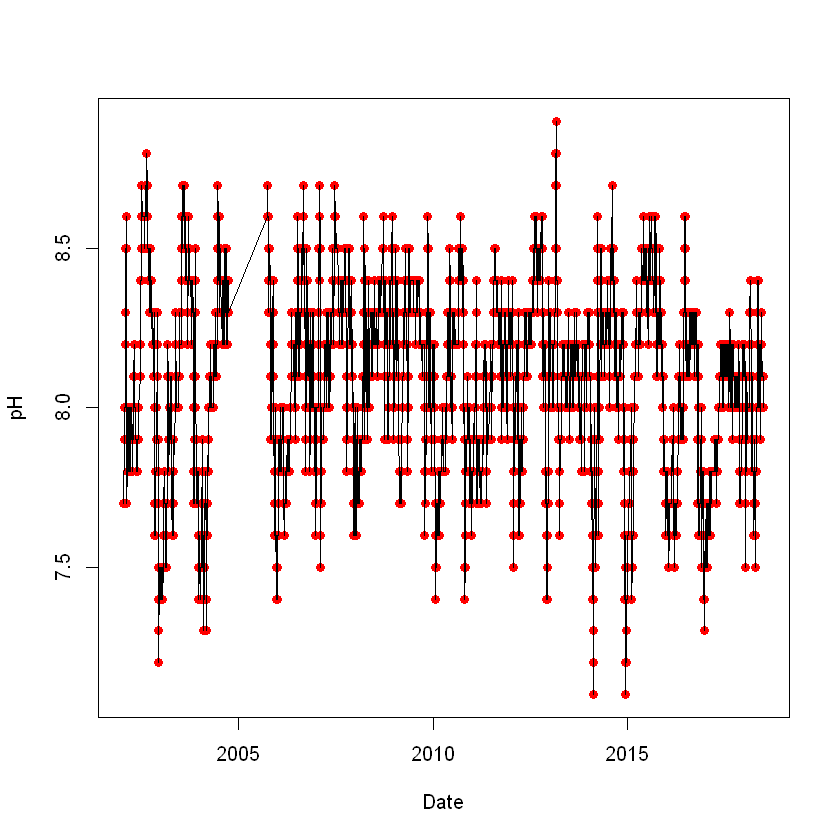

In [8]:

###################============Plot time series of pH============##########
plot(DailypH_1$Date,DailypH_1$pH,xlab="Date",ylab="pH",pch=19,col="red")
lines(DailypH_1$Date,DailypH_1$pH)

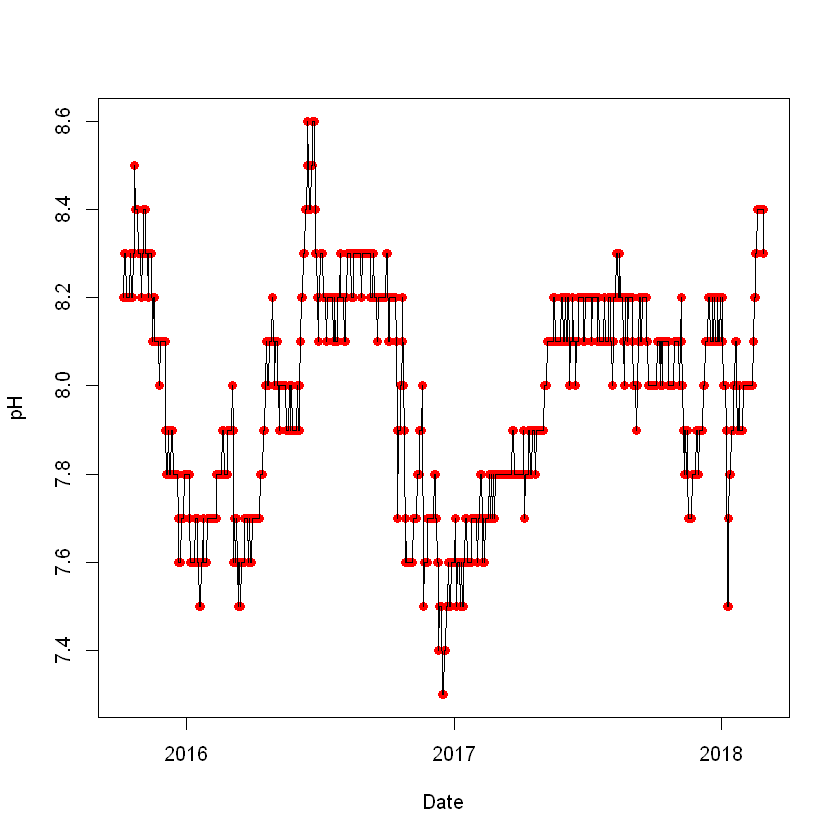

In [9]:
#Zoom into one year pH
plot(DailypH_1$Date[4500:5374],DailypH_1$pH[4500:5374],xlab="Date",ylab="pH",pch=19,col="red")
lines(DailypH_1$Date[4500:5374],DailypH_1$pH[4500:5374])

## Is pH affected by rain?

OPTION 2 - pH is affected by rain
How would we test this? What type of sensors?
Facilitator introduces the idea of discharge. This refers to the volume of water in the river and is often used as a proxy for rainfaill. This is a parameter that our sensors measure so we can test it. What are the units for discharge? Use this website to help you http://www.geography.learnontheinternet.co.uk/topics/discharge.html **Write out as won't have time to look it up.

## Fetch Daily Discharge to test the hypothesis about rain

In [10]:
#####Fetch daily discharge data
DailyQ_1 <- getFlowDaily(siteID,"00060",startDate,endDate,convert=TRUE,interactive=FALSE,"00003")
DailypH<-merge(DailypH_1,DailyQ_1[,c(1,2)],by="Date") #This merges the data together

# Here we are going to categorize our data as low flow verus storm periods
DailypH$storm<-NA
DailypH$storm[DailypH$Q < 20]<-"lowFlow" #values of discharge below 12 m3/s are low flow
DailypH$storm[DailypH$Q > 20]<-"storm" #values of discharge above 12 m3/s are storms


#Here we are going to categorize our dates as pre-fire and post-fire again. Since we only did this for pH we have to do it again for the discharge
#What does it mean to categorize in this way?
DailypH$prepost<-NA
DailypH$prepost[DailypH$Date < "2017-09-30"]<-"preFire" #dates before Sept. 30, 2017 are 0 for pre
DailypH$prepost[DailypH$Date > "2017-09-30"]<-"postFire" #dates after Sept. 30, 2017 are 1 for post


## Plot Discharge versus pH

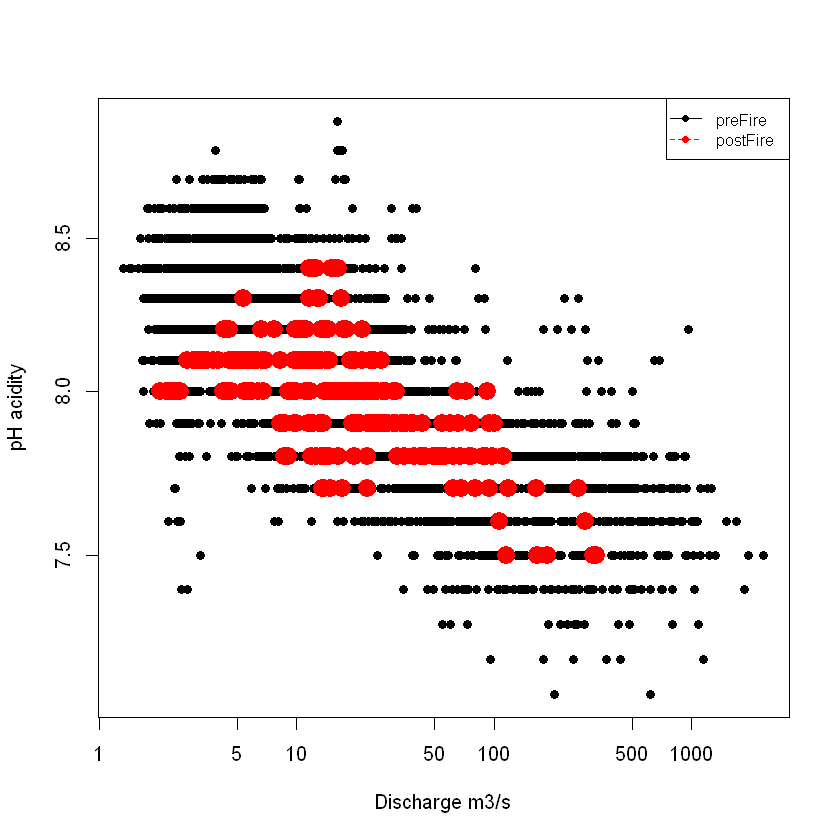

In [11]:
plot(DailypH$Q[DailypH$prepost=="preFire"],DailypH$pH[DailypH$prepost=="preFire"],col="black",pch=19,log="xy",ylab="pH acidity",xlab="Discharge m3/s")
points(DailypH$Q[DailypH$prepost=="postFire"],DailypH$pH[DailypH$prepost=="postFire"],col="red",pch=19,cex=2)
legend('topright',legend=c("preFire", "postFire"), pch=19,col=c("black", "red"), lty=1:2, cex=0.8)


## Questions

############=======Questions============##########

Question: Why would pH would be more "basic" post-Fire during storm events

Question: On average, during low-flow periods what are the differences in acidity pre versus post-fire?

Question: What is the pH or acidity of clean rainfall? ***Write out facilitators notes as there won't be time to look it up. https://www3.epa.gov/acidrain/education/site_students/phscale.html

Question: What is the main mineral in ash? **Write out facilitator's notes as there won't be time to look it up. https://en.wikipedia.org/wiki/Wood_ash

## Plot Boxplots of pre-and-post fire pH with Discharge

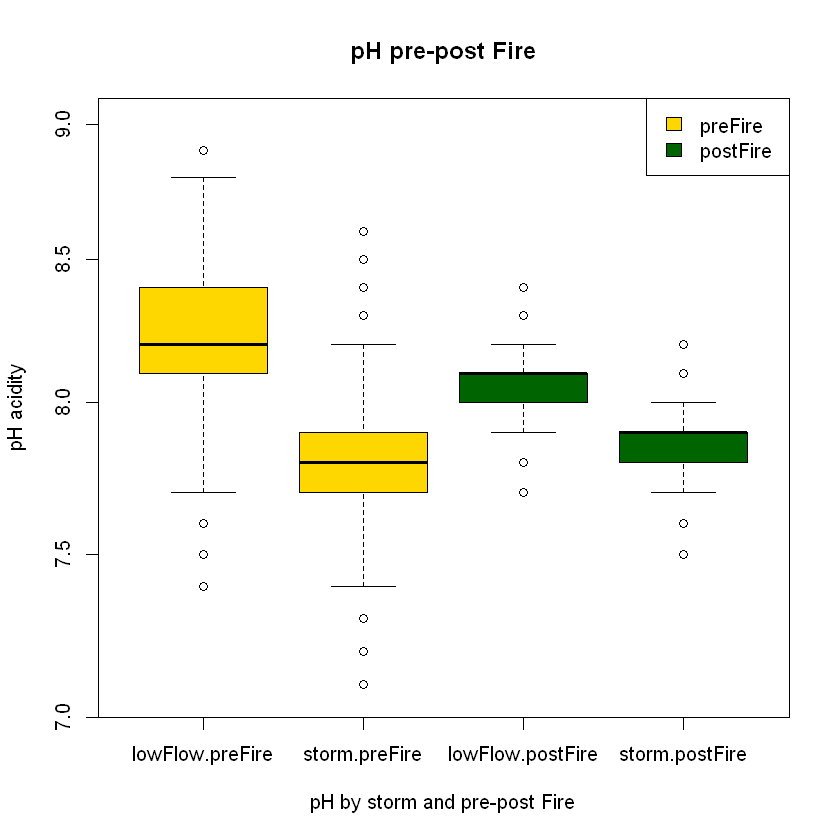

In [12]:
#############################Color the pH box plot by pre-post fire and combine by storm or low-flow========

# This is how you can control the order of what appears in the boxplot
DailypH$prepost<-factor(DailypH$prepost, levels=c("preFire", "postFire"))

boxplot(pH~storm*prepost, data = DailypH,col=(c("gold","gold","darkgreen","darkgreen")), main = "pH pre-post Fire",xlab= "pH by storm and pre-post Fire",ylab = "pH acidity",ylim = c(7, ceiling( max(DailypH$pH)) + 0.1), yaxs= "i",log="y")

legend("topright",legend = c("preFire" , "postFire"), fill = c( "gold" , "darkgreen") )

## Questions

Question: Does calcium carbonate make the water more acidic or more basic? Calcim carbonate reacts with acids and make water more basic via the reaction: it reacts with acids, releasing carbon dioxide:
 CaCO3(s) + 2H+(aq) → Ca2+(aq) + CO2(g) + H2O (l)

Question: On average, is discharge this year lower or higher on average for the storms after the fire? Lower. So this means there is a decreased input of acidic rainfall entering the river. 

Question: How is the ash leachate (i.e. calcium carbonate rich water) impacting pH when we have a dry year with a decreased number of storms?


## Additional Hypothesis Development

############=======Hypothesis development============##########

Question: How can we explain pH using both our knowledge about fire-ash and rainfall?

Hypothesis 1: Becuase we have had fewer storms, a decreased amount of "acidic" rainfall has entered the system.
Question 1: How do we test this?
Method 1: What should we measure to confirm or deny this?


Hypothesis 2: Because we had the fire, any rainfall falling on the burned zones causes more ash (i.e. calcium carbonate) to runoff into the river. 
Question 2: How do we test this?
Method 2: What should we measure to confirm or deny this?
